# Community Detection
This notebook demonstrates **community detection on graphs** using the `rice_ml` package and compares multiple approaches on:

1. A small **toy graph** with obvious disconnected groups  
2. The classic **Zachary’s Karate Club** network

We will compare:
- **Connected Components** (baseline: purely connectivity-based)
- **Label Propagation** (iterative neighbor-majority labeling)
- **Ground Truth** (Karate Club’s known split, for evaluation)

> Note: The `rice_ml` package itself is implemented from scratch (NumPy-only).  
> In this notebook we use `networkx` for loading/visualizing graphs


## 1. Setup

In [25]:
from __future__ import annotations

import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Optional (recommended) for graphs + plotting convenience
try:
    import networkx as nx
    have_nx = True
except Exception:
    have_nx = False

# Optional (recommended) for evaluation metrics
try:
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
    have_sklearn = True
except Exception:
    have_sklearn = False

np.random.seed(42)

def find_repo_root(start: Path) -> Path:
    """Find the repository root by searching upward for pyproject.toml + src/."""
    cur = start.resolve()
    for _ in range(8):
        if (cur / "pyproject.toml").exists() and (cur / "src").exists():
            return cur
        cur = cur.parent
    raise FileNotFoundError("Could not find repo root (pyproject.toml + src). Run from inside the repo.")

# Make `src/` importable when running notebooks directly
repo_root = find_repo_root(Path.cwd())
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from rice_ml.unsupervised_learning.community_detection import CommunityDetection
print("Repo root:", repo_root)
print("Imported CommunityDetection from:", CommunityDetection.__module__)
print("networkx available?", have_nx, "| sklearn available?", have_sklearn)


Repo root: C:\Users\sutt6\OneDrive\Desktop\CMOR438\CMOR438
Imported CommunityDetection from: rice_ml.unsupervised_learning.community_detection
networkx available? True | sklearn available? True


## 2. Helper functions

In [26]:
def adjacency_stats(A: np.ndarray) -> dict:
    """Basic adjacency summary (assumes nonnegative weights)."""
    A = np.asarray(A, dtype=float)
    n = A.shape[0]
    # count undirected edges for symmetric graphs; otherwise count nonzeros / 2 heuristic only if symmetric
    nnz = int(np.sum(A != 0))
    total_w = float(np.sum(A))
    # degree (unweighted)
    deg = np.sum(A != 0, axis=1)
    return {
        "n_nodes": int(n),
        "n_edges(nonzero)": int(nnz // 2) if np.allclose(A, A.T) else int(nnz),
        "total_edge_weight": total_w,
        "degree_min": int(deg.min()) if n else 0,
        "degree_mean": float(deg.mean()) if n else 0.0,
        "degree_max": int(deg.max()) if n else 0,
    }

def community_sizes(labels: np.ndarray) -> dict:
    labels = np.asarray(labels)
    uniq, cnt = np.unique(labels, return_counts=True)
    return dict(zip(uniq.tolist(), cnt.tolist()))

def labels_to_communities(labels: np.ndarray):
    labels = np.asarray(labels)
    comms = []
    for lab in np.unique(labels):
        comms.append(set(np.where(labels == lab)[0]))
    return comms

def try_modularity(G, labels: np.ndarray) -> float | None:
    if not have_nx:
        return None
    try:
        from networkx.algorithms.community.quality import modularity
        return float(modularity(G, labels_to_communities(labels)))
    except Exception:
        return None

def compare_to_ground_truth(labels_pred: np.ndarray, labels_true: np.ndarray) -> dict:
    out = {}
    if have_sklearn:
        out["ARI"] = float(adjusted_rand_score(labels_true, labels_pred))
        out["NMI"] = float(normalized_mutual_info_score(labels_true, labels_pred))
    return out

def plot_graph(G, *, pos=None, labels=None, title="Graph", node_size=350):
    if not have_nx:
        print("networkx not available; skipping plot.")
        return None

    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(7, 5))

    if labels is None:
        nx.draw(G, pos=pos, with_labels=True, node_size=node_size, edge_color="gray")
        plt.title(title)
        plt.show()
        return pos

    labs = np.asarray(labels)
    uniq = np.unique(labs)
    # map arbitrary labels to 0..K-1 for coloring
    lab_to_int = {lab: i for i, lab in enumerate(uniq)}
    ints = np.array([lab_to_int[v] for v in labs], dtype=int)
    denom = max(1, len(uniq) - 1)
    colors = plt.cm.tab20(ints / denom)

    nx.draw(G, pos=pos, with_labels=True, node_color=colors, node_size=node_size, edge_color="gray")
    plt.title(f"{title} | K={len(uniq)}")
    plt.show()
    return pos


## 3. Toy graph example (disconnected communities)

We build a toy graph with **three disconnected components**:
- Community 0: nodes 0–3
- Community 1: nodes 4–7
- Community 2: nodes 8–9

This is a sanity check: **connected components should recover 3 communities exactly**, and most other methods should agree.


Toy graph stats: {'n_nodes': 10, 'n_edges(nonzero)': 7, 'total_edge_weight': 14.0, 'degree_min': 1, 'degree_mean': 1.4, 'degree_max': 2}


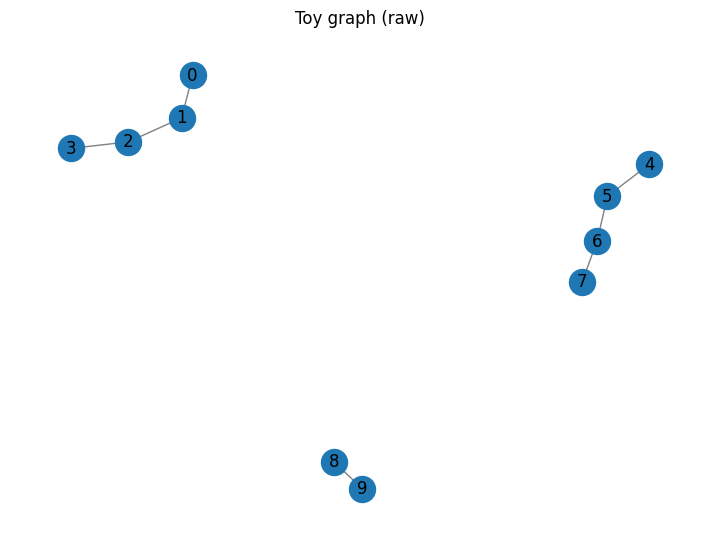

In [27]:
# Build toy adjacency matrix (10 nodes, 3 disconnected components)
n = 10
A_toy = np.zeros((n, n), dtype=float)

# component 0: chain 0-1-2-3
toy_edges = [(0,1),(1,2),(2,3)]
# component 1: chain 4-5-6-7
toy_edges += [(4,5),(5,6),(6,7)]
# component 2: edge 8-9
toy_edges += [(8,9)]

for i,j in toy_edges:
    A_toy[i,j] = 1.0
    A_toy[j,i] = 1.0

print("Toy graph stats:", adjacency_stats(A_toy))

if have_nx:
    G_toy = nx.from_numpy_array(A_toy)
    pos_toy = plot_graph(G_toy, title="Toy graph (raw)")


### 3.1 Run multiple methods on the toy graph


Connected Components
  Communities found: 3
  Community sizes: {0: 4, 1: 4, 2: 2}

Label Propagation
  Communities found: 3
  Community sizes: {0: 4, 1: 4, 2: 2}


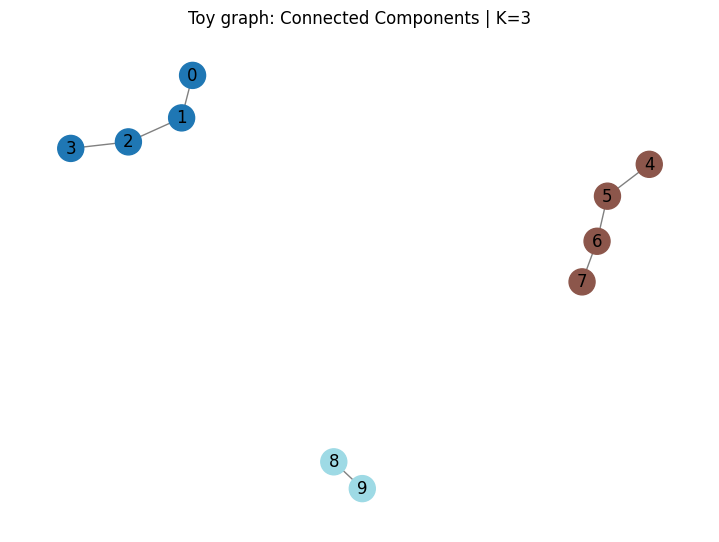

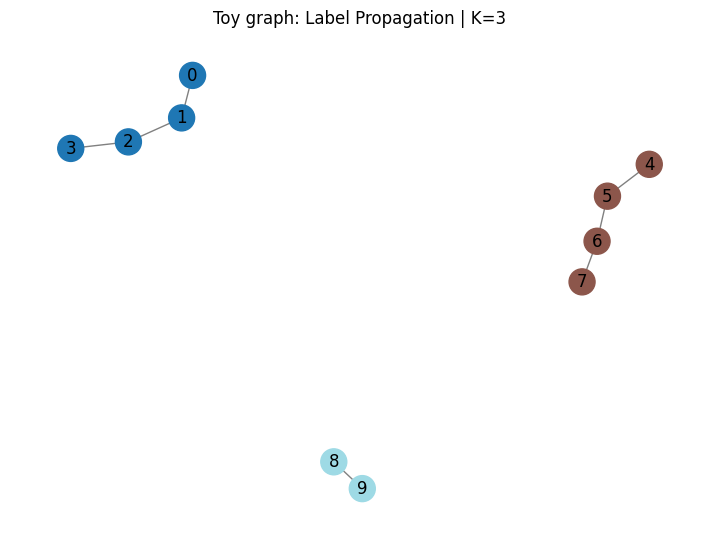

In [29]:
methods = [
    ("Connected Components", dict(method="connected_components")),
    ("Label Propagation", dict(method="label_propagation", max_iter=200, random_state=42)),
]

results_toy = {}

for name, kwargs in methods:
    model = CommunityDetection(**kwargs)
    labels = model.fit_predict(A_toy)
    results_toy[name] = labels

    print(f"\n{name}")
    print("  Communities found:", len(np.unique(labels)))
    print("  Community sizes:", community_sizes(labels))

# Plot side-by-side (same layout) if networkx exists
if have_nx:
    for name, _ in methods:
        plot_graph(G_toy, pos=pos_toy, labels=results_toy[name], title=f"Toy graph: {name}")


## 4. Zachary’s Karate Club example

The Karate Club network is **connected** (there is a path between any two nodes).  
So:
- **Connected Components** will return **1** community by design.
- **Label Propagation** and **Louvain** can still find **sub-communities** inside a connected graph.

We will also derive **ground truth labels** from the node attribute `club`:
- `Mr. Hi`
- `Officer`


Karate Club stats: {'n_nodes': 34, 'n_edges(nonzero)': 78, 'total_edge_weight': 462.0, 'degree_min': 1, 'degree_mean': 4.588235294117647, 'degree_max': 17}
Connected? True


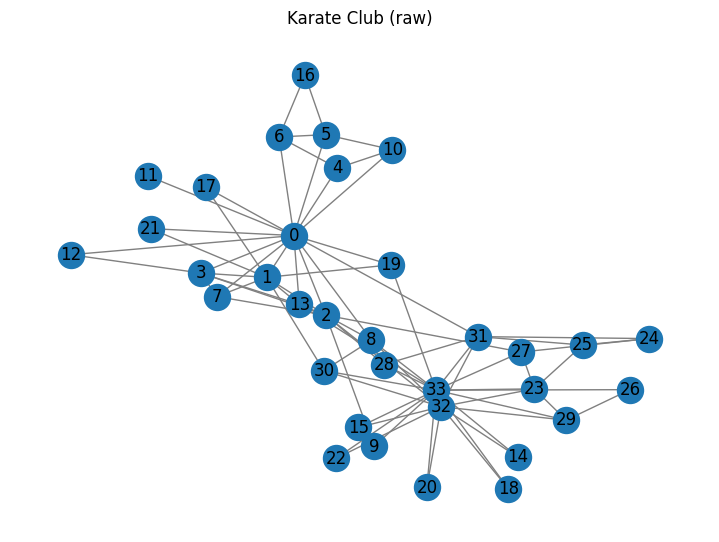

Ground truth sizes: {0: 17, 1: 17}


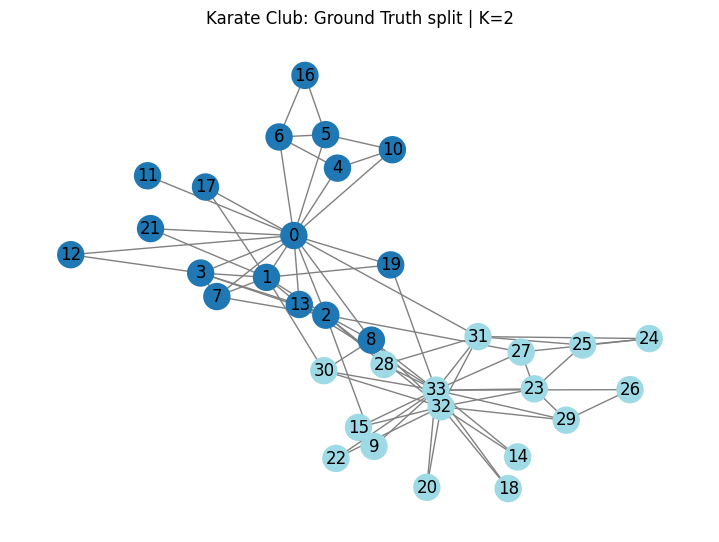

In [33]:
if not have_nx:
    raise RuntimeError("This notebook's Karate Club section requires networkx. Please install it (pip install networkx).")

G = nx.karate_club_graph()
A_karate = nx.to_numpy_array(G, dtype=float)

print("Karate Club stats:", adjacency_stats(A_karate))
print("Connected?", nx.is_connected(G))

pos = plot_graph(G, title="Karate Club (raw)")

# Ground truth: map 'club' -> {0,1}
club = nx.get_node_attributes(G, "club")
labels_gt = np.array([0 if club[i] == "Mr. Hi" else 1 for i in range(G.number_of_nodes())], dtype=int)

print("Ground truth sizes:", community_sizes(labels_gt))
_ = plot_graph(G, pos=pos, labels=labels_gt, title="Karate Club: Ground Truth split")


### 4.1 Run and compare multiple methods

In [ ]:
methods = [
    ("Label Propagation", dict(method="label_propagation", max_iter=200, random_state=42)),
]

summary_rows = []

for name, kwargs in methods:
    model = CommunityDetection(**kwargs)
    labels = model.fit_predict(A_karate)

    sizes = community_sizes(labels)
    K = len(np.unique(labels))
    mod = try_modularity(G, labels)
    agree = compare_to_ground_truth(labels, labels_gt)

    row = {
        "method": name,
        "K": K,
        "sizes": sizes,
        "modularity": mod,
        **agree,
    }
    summary_rows.append(row)

    print(f"\n{name}")
    print("  Communities found:", K)
    print("  Community sizes:", sizes)
    if mod is not None:
        print("  Modularity:", round(mod, 4))
    if agree:
        print("  Agreement vs GT:", {k: round(v, 4) for k, v in agree.items()})

    plot_graph(G, pos=pos, labels=labels, title=f"Karate Club: {name}")

## 5. Interpretation

### Toy graph
- The toy graph has **three disconnected components**, so `connected_components` should recover **exactly 3 communities**.
- Label propagation typically match as well on this clean structure.

### Karate Club
- Karate Club is **connected**, so `connected_components` returns **one** community by design.
- **Label propagation** is intended to detect **sub-communities within connected networks**, so it can split the graph into 2 groups.
- The **ground truth** split is known (Mr. Hi vs Officer). We measure agreement using **ARI/NMI** (if `scikit-learn` is installed).

### Key takeaway
Different methods solve different problems:
- *Connectivity-based* methods answer: “How many disconnected pieces exist?”
- *Community detection* methods answer: “What dense substructures exist inside a connected graph?”


## 6. Notes on reproducibility

- We set `random_state=42` where applicable.
- Label propagation can be sensitive to node update order; increasing `max_iter` may change results.
